In [1]:
import pandas as pd

import numpy as np

from scipy.stats import boxcox

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(100)

In [3]:
pd.options.display.max_rows = 100

## Baseline Score
- Submit sample_submission.csv to Kaggle to get a baseline score for our analysis
- Evaluate Score is rmse between predicted price and actual price
#### Baseline score is: 0.4089

## Load Data and EDA (Continuous only)

In [4]:
file_path = "../../Dataset/house-prices-advanced-regression-techniques/"

In [473]:
train = pd.read_csv(file_path + "train.csv")
test = pd.read_csv(file_path + "test.csv")

In [474]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


### Missing Values

In [475]:
temp = train.isnull().sum()
temp[temp != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [476]:
train['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [477]:
# Utilities provide no useful info to the data...
train.drop('Utilities', axis=1, inplace=True)
test.drop('Utilities', axis=1, inplace=True)

In [478]:
# Replace Null that represents no such values
train['Alley'] = train['Alley'].fillna('None')
train['MasVnrType'] = train['MasVnrType'].fillna('None')
# Since no MasVnr, we fill the area as 0
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)

train['BsmtQual'] = train['BsmtQual'].fillna('None')
train['BsmtCond'] = train['BsmtCond'].fillna('None')
train['BsmtExposure'] = train['BsmtExposure'].fillna('None')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('None')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('None')

train['FireplaceQu'] = train['FireplaceQu'].fillna('None')

train['GarageType'] = train['GarageType'].fillna('None')
train['GarageFinish'] = train['GarageFinish'].fillna('None')
train['GarageQual'] = train['GarageQual'].fillna('None')
train['GarageCond'] = train['GarageCond'].fillna('None')
# Continuous Variable
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)

train['PoolQC'] = train['PoolQC'].fillna('None')
train['Fence'] = train['Fence'].fillna('None')
train['MiscFeature'] = train['MiscFeature'].fillna('None')

In [479]:
####
# Same thing for test set
test['Alley'] = test['Alley'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')
# Since no MasVnr, we fill the area as 0
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

test['BsmtQual'] = test['BsmtQual'].fillna('None')
test['BsmtCond'] = test['BsmtCond'].fillna('None')
test['BsmtExposure'] = test['BsmtExposure'].fillna('None')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('None')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('None')

test['FireplaceQu'] = test['FireplaceQu'].fillna('None')

test['GarageType'] = test['GarageType'].fillna('None')
test['GarageFinish'] = test['GarageFinish'].fillna('None')
test['GarageQual'] = test['GarageQual'].fillna('None')
test['GarageCond'] = test['GarageCond'].fillna('None')
# Continuous Variable
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

test['PoolQC'] = test['PoolQC'].fillna('None')
test['Fence'] = test['Fence'].fillna('None')
test['MiscFeature'] = test['MiscFeature'].fillna('None')

In [480]:
# 1 Nan Values fill with mode. This NA maybe mistake.
print(train['Electrical'].value_counts())
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


In [481]:
# Fill Null with train values to avoid data leakage
test['Electrical'] = test['Electrical'].fillna(train['Electrical'].mode()[0])

In [482]:
# Use KNN Imputer to impute LotFrontage
imputer = KNNImputer(n_neighbors=3)
knn_df = pd.get_dummies(train[['LotFrontage','Neighborhood', 'LotArea', 'LotConfig','LotShape']])

train['LotFrontage'] = imputer.fit_transform(knn_df)[:,0]

In [483]:
# Only Transform no fit to avoid data leakage
test_knn_df = pd.get_dummies(test[['LotFrontage','Neighborhood', 'LotArea', 'LotConfig','LotShape']])
test['LotFrontage'] = imputer.transform(test_knn_df)[:,0]

In [484]:
# Check on train missing values
temp = train.isnull().sum()
temp[temp != 0]

Series([], dtype: int64)

In [485]:
# Check on test missing values
temp2 = test.isnull().sum()
temp2[temp2 != 0]

MSZoning        4
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
SaleType        1
dtype: int64

In [486]:
# We need to figure out how to impute missing values on the test dataset, too
# Since I don't want to create new columns/categories, I won't fillna with None here
# Because there is no None in train data. I will fill with mode
test['MSZoning'] = test['MSZoning'].fillna(train['MSZoning'].mode()[0])
print('Fill MSZoning with train dataset mode:', train['MSZoning'].mode()[0])

# test['Utilities'] = test['Utilities'].fillna(train['Utilities'].mode()[0])
# print('Fill Utilities with train dataset mode:', train['Utilities'].mode()[0])

test['Exterior1st'] = test['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
print('Fill Exterior1st with train dataset mode:', train['Exterior1st'].mode()[0])

test['Exterior2nd'] = test['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
print('Fill Exterior2nd with train dataset mode:', train['Exterior2nd'].mode()[0])

test['KitchenQual'] = test['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
print('Fill KitchenQual with train dataset mode:', train['KitchenQual'].mode()[0])

test['Functional'] = test['Functional'].fillna('Typ')
##print('Fill MSZoning with train dataset mode:', train['Functional'].mode()[0])

test['SaleType'] = test['SaleType'].fillna(train['SaleType'].mode()[0])
print('Fill SaleType with train dataset mode:', train['SaleType'].mode()[0])

Fill MSZoning with train dataset mode: RL
Fill Exterior1st with train dataset mode: VinylSd
Fill Exterior2nd with train dataset mode: VinylSd
Fill KitchenQual with train dataset mode: TA
Fill SaleType with train dataset mode: WD


In [487]:
# Fill test continuous missing values with 0 because probably they don't have it
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)

In [488]:
# Check on test missing values
temp2 = test.isnull().sum()
temp2[temp2 != 0]

Series([], dtype: int64)

### Outliers Detection

In [489]:
# Numerical but actually categorical
cat_as_num = ['MSSubClass', 'OverallQual', 'OverallCond', 'Id']
year = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

In [490]:
# numeric columns
num_col = [c for c in train.columns if train[c].dtypes in ['int64', 'float64'] and c not in cat_as_num 
           and c not in year]
# categorical columns
cat_col = [c for c in train.columns if c not in num_col and c != 'Id']

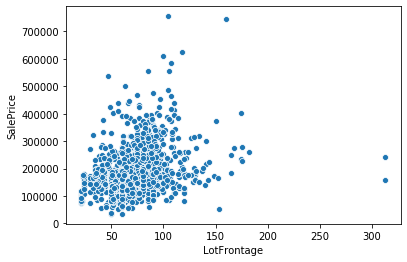

In [491]:
sns.scatterplot(train['LotFrontage'], train['SalePrice'])

In [492]:
# There are two outliers with really large LotFrontage but small Sale Price
# Remove them
train = train[~((train['LotFrontage']>200) & (train['SalePrice']<300000))]

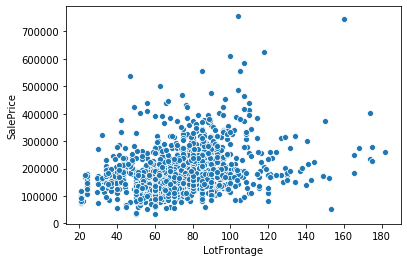

In [493]:
sns.scatterplot(train['LotFrontage'], train['SalePrice'])

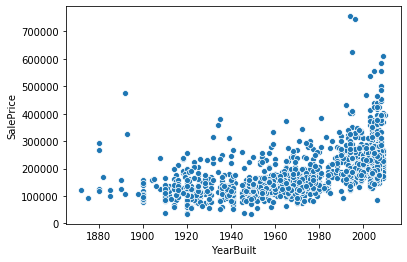

In [494]:
sns.scatterplot(train['YearBuilt'], train['SalePrice'])

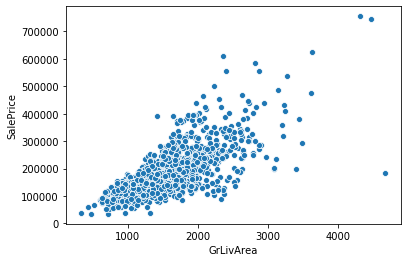

In [495]:
sns.scatterplot(train['GrLivArea'], train['SalePrice'])

In [496]:
# We found that there is one outliers with really large GrLivArea but really little SalePrice
# We need to remove that outliers
train = train[~((train['GrLivArea']>4000) & (train['SalePrice']<250000))]

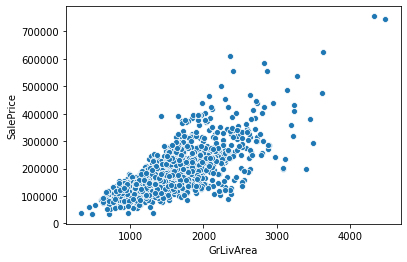

In [497]:
sns.scatterplot(train['GrLivArea'], train['SalePrice'])

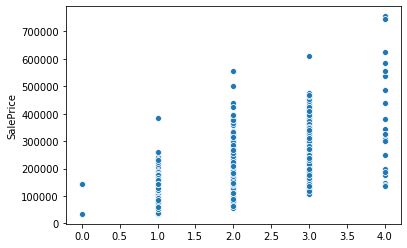

In [498]:
sns.scatterplot(train['FullBath']+train['HalfBath'], train['SalePrice'])

In [499]:
train[num_col].describe()

LotFrontage        LotArea   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1457.000000    1457.000000  1457.000000  1457.000000  1457.000000   
mean     70.901853   10448.138641   102.260124   438.836651    46.645161   
std      22.666718    9852.281853   179.151331   433.117601   161.471529   
min      21.000000    1300.000000     0.000000     0.000000     0.000000   
25%      60.000000    7540.000000     0.000000     0.000000     0.000000   
50%      70.000000    9473.000000     0.000000   381.000000     0.000000   
75%      82.000000   11600.000000   164.000000   712.000000     0.000000   
max     182.000000  215245.000000  1600.000000  2188.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  ...  \
count  1457.000000  1457.000000  1457.000000  1457.000000   1457.000000  ...   
mean    567.376115  1052.857927  1158.226493   345.999314      5.856555  ...   
std     442.110179   414.943813   371.401570   435.479096     48.672424  ...   
min       0.000000     0.000000   334.000000     0.000000      0.000000  ...   
25%     223.000000   796.000000   882.000000     0.000000      0.000000  ...   
50%     479.000000   991.000000  1086.000000     0.000000      0.000000  ...   
75%     808.000000  1297.000000  1390.000000   728.000000      0.000000  ...   
max    2336.000000  3206.000000  3228.000000  2065.000000    572.000000  ...   

        GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  1457.000000  1457.000000  1457.000000  1457.000000    1457.000000   
mean      1.765957   472.027454    94.148936    46.277282      21.999314   
std       0.747336   212.310363   125.368798    65.324107      61.173949   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       1.000000   330.000000     0.000000     0.000000       0.000000   
50%       2.000000   479.000000     0.000000    25.000000       0.000000   
75%       2.000000   576.000000   168.000000    68.000000       0.000000   
max       4.000000  1390.000000   857.000000   547.000000     552.000000   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal      SalePrice  
count  1457.000000  1457.000000  1457.000000   1457.000000    1457.000000  
mean      3.416609    15.091970     2.435141     43.578586  180891.006177  
std      29.347109    55.810633    38.223013    496.629946   79506.233040  
min       0.000000     0.000000     0.000000      0.000000   34900.000000  
25%       0.000000     0.000000     0.000000      0.000000  129900.000000  
50%       0.000000     0.000000     0.000000      0.000000  163000.000000  
75%       0.000000     0.000000     0.000000      0.000000  214000.000000  
max     508.000000   480.000000   738.000000  15500.000000  755000.000000  

[8 rows x 29 columns]

#### Conclusion
- ranges are very different so if using regression, we need to standardize the feature.

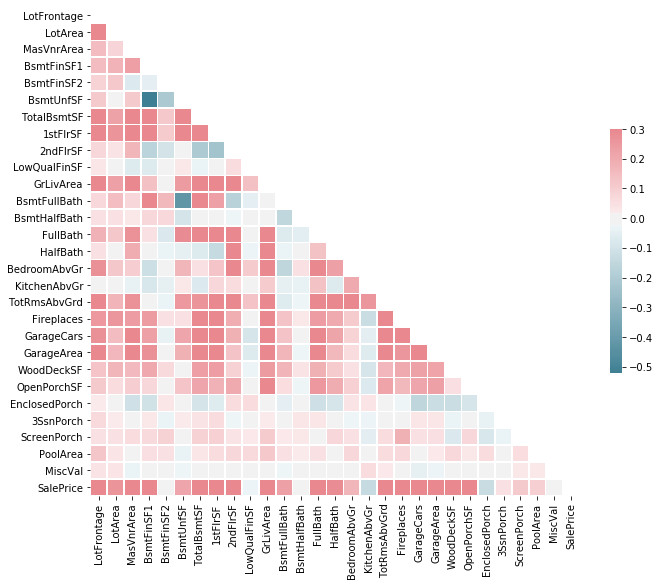

In [500]:
# Get correlation plot
correlation_matrix = train[num_col].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

- many high correlated features, if using regression, we need to pay attention to this.
- BsmtunfSF has high negative correlation with BsmfFinSF1,BsmtFullBath
- Enclosed Porch has negative correlation with YearBuild
- All areas related features are high correlated with each other
- SalePrice has high correlation with more than 20 variables

## Feature Engineer
### Variable Transformation

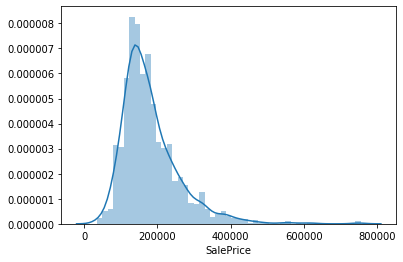

In [501]:
# check the distribution of Sale Price
sns.distplot(train['SalePrice'])

In [502]:
# For regression model to work, we need transform target variables.
# Also, this competition evaluate on log of target variables
train['log_SalePrice'] = np.log1p(train['SalePrice'])

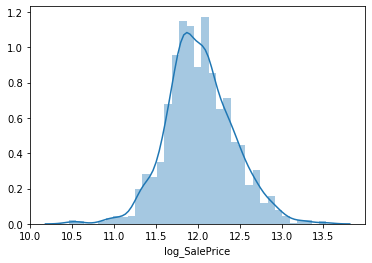

In [503]:
sns.distplot(train['log_SalePrice'])

In [504]:
train[num_col].skew(axis=0, skipna=True).sort_values()

GarageCars       -0.341670
FullBath          0.032573
GarageArea        0.132024
BedroomAbvGr      0.213695
TotalBsmtSF       0.510858
BsmtFullBath      0.592257
Fireplaces        0.633178
TotRmsAbvGrd      0.662553
HalfBath          0.678958
LotFrontage       0.738126
BsmtFinSF1        0.764463
2ndFlrSF          0.811915
1stFlrSF          0.887763
BsmtUnfSF         0.920031
GrLivArea         1.013259
WoodDeckSF        1.544917
SalePrice         1.883068
OpenPorchSF       2.339021
MasVnrArea        2.695262
EnclosedPorch     3.085809
BsmtHalfBath      4.098469
ScreenPorch       4.117285
BsmtFinSF2        4.250256
KitchenAbvGr      4.483125
LowQualFinSF      9.001760
3SsnPorch        10.293487
LotArea          12.609035
PoolArea         15.943422
MiscVal          24.451726
dtype: float64

In [505]:
train['Total SF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

train['House Age'] = train['YrSold'] - train['YearBuilt']

In [506]:
test['Total SF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

test['House Age'] = test['YrSold'] - test['YearBuilt']

In [507]:
# Log transform to remove skewness
for col in num_col:
    if abs(train[col].skew(skipna=True)) > 0.75 and col != 'SalePrice':
        train[col] = np.log1p(train[col])

In [508]:
# Test transformation
for col in num_col:
    if col != 'SalePrice':
        if abs(test[col].skew(skipna=True)) > 0.75:
            test[col] = np.log1p(test[col])

In [509]:
train[num_col].skew(axis=0, skipna=True).sort_values()

BsmtUnfSF        -2.184438
BsmtFinSF1       -0.617019
GarageCars       -0.341670
LotArea          -0.184741
GrLivArea        -0.069734
OpenPorchSF      -0.024272
1stFlrSF          0.005616
FullBath          0.032573
GarageArea        0.132024
WoodDeckSF        0.155236
BedroomAbvGr      0.213695
2ndFlrSF          0.291571
MasVnrArea        0.505176
TotalBsmtSF       0.510858
BsmtFullBath      0.592257
Fireplaces        0.633178
TotRmsAbvGrd      0.662553
HalfBath          0.678958
LotFrontage       0.738126
SalePrice         1.883068
EnclosedPorch     2.108812
BsmtFinSF2        2.519985
ScreenPorch       3.146253
KitchenAbvGr      3.864695
BsmtHalfBath      3.928274
MiscVal           5.164816
LowQualFinSF      7.452254
3SsnPorch         7.726645
PoolArea         15.512308
dtype: float64

In [510]:
train['LotShape'].value_counts()

Reg    925
IR1    483
IR2     40
IR3      9
Name: LotShape, dtype: int64

In [511]:
def variable_transfer(data):
    
    temp_hold = data.copy()
    # Change cat as num to cat
    temp_hold['MSSubClass'] = temp_hold['MSSubClass'].astype('str')

    # Some features can use number encoding to refect ordinal meaning
    temp_hold['Street'] = temp_hold['Street'].replace({'Grvl': 0, 'Pave':1})

    temp_hold['Alley'] = temp_hold['Alley'].replace({'None':0, 'Grvl': 1, 'Pave':2})
    
    temp_hold['LotShape'] = temp_hold['LotShape'].replace({'IR3':0, 'IR2':1, 'IR1': 2, 'Reg':3})
    
    temp_hold['LandContour'] = temp_hold['LandContour'].replace({'Low': 0, 'Lvl':1, 'Bnk':2, 'HLS':3})

#     temp_hold['Utilities'] = temp_hold['Utilities'].replace({'ElO': 0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3})

    temp_hold['LandSlope'] = temp_hold['LandSlope'].replace({'Gtl':0, 'Mod':1, 'Sev':2})

    temp_hold['ExterCond'] = temp_hold['ExterCond'].replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    temp_hold['ExterQual'] = temp_hold['ExterQual'].replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

    temp_hold['BsmtQual'] = temp_hold['BsmtQual'].replace({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    temp_hold['BsmtCond'] = temp_hold['BsmtCond'].replace({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

    temp_hold['GarageQual'] = temp_hold['GarageQual'].replace({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    temp_hold['GarageCond'] = temp_hold['GarageCond'].replace({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

    temp_hold['BsmtExposure'] = temp_hold['BsmtExposure'].replace({'None':0, 'No':1, 'Mn':2, 'Av':3,'Gd':4})

    temp_hold['BsmtFinType1'] = temp_hold['BsmtFinType1'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    temp_hold['BsmtFinType2'] = temp_hold['BsmtFinType2'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})

    temp_hold['HeatingQC'] = temp_hold['HeatingQC'].replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    temp_hold['CentralAir'] = temp_hold['CentralAir'].replace({'N':0, 'Y':1})

    temp_hold['KitchenQual'] = temp_hold['KitchenQual'].replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    temp_hold['FireplaceQu'] = temp_hold['FireplaceQu'].replace({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

    temp_hold['Functional'] = temp_hold['Functional'].replace({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5,
                                                       'Min1':6, 'Typ': 7})

    temp_hold['GarageFinish'] = temp_hold['GarageFinish'].replace({'None':0,'Unf':1,'RFn':2,'Fin':3})

    temp_hold['PavedDrive'] = temp_hold['PavedDrive'].replace({'N':1, 'P':2, 'Y':3})

    temp_hold['PoolQC'] = temp_hold['PoolQC'].replace({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    temp_hold['Fence'] = temp_hold['Fence'].replace({'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
    
    return temp_hold
    

In [512]:
train = train.drop(['Id', 'SalePrice'], axis=1).copy()

In [513]:
################################## Save data here to save time future ############################
train.to_csv(file_path+"transfer_ready_train.csv", index=False)
test.to_csv(file_path+"transfer_ready_test.csv", index=False)

In [516]:
lb_train = variable_transfer(train)
lb_test = variable_transfer(test)

In [517]:
ready_train = pd.get_dummies(lb_train)
X = ready_train.drop('log_SalePrice', axis=1)
y = ready_train['log_SalePrice']

In [518]:
# Onehot transfer test
onehot_test = pd.get_dummies(lb_test)

In [519]:
# Set missing onehot features to 0
miss_col = set(X.columns)-set(onehot_test.columns)

for c in miss_col:
    onehot_test[c] = 0

# There is no better way to handle unseen categories in test data. 
# I will just create this column and leave it as 0 for now
# Set missing onehot features to 0
miss_col = set(onehot_test.columns)-set(X.columns)

for c in miss_col:
    if c != 'Id':
        X[c] = 0

## Model

In [228]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold

import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

In [229]:
def check_performance(model, X, y):
    kf = KFold(5, shuffle=True, random_state=100).get_n_splits(X.values)
    # return average log rmse performance
    r = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return r.mean(), r.std()

In [284]:
def tune_performance(model, X, y, param_dist, n_iter = 40):
    grid = RandomizedSearchCV(model, param_distributions=param_dist, 
                              scoring='neg_mean_squared_error', cv=3,
                              n_iter = n_iter, refit=True)
    grid.fit(X, y)
    return np.sqrt(-grid.best_score_), grid.best_estimator_

In [376]:
one_hot_average = []

#### Ridge One Hot

In [521]:
rid_param_dist = {'ridge__alpha': np.concatenate([np.linspace(0,1,100), np.array([20, 30, 40])])}

In [522]:
rid = make_pipeline(RobustScaler(), Ridge(random_state=100))

In [523]:
rid_r, rid_m = tune_performance(rid, X, y, param_dist=rid_param_dist)

In [524]:
print('Ridge with one hot result:', rid_r)

Ridge with one hot result: 0.11407318296225329


In [525]:
rid_one_hot_r = check_performance(rid_m, X, y)
print(rid_one_hot_r)

(0.11200702912219122, 0.003650117105708812)


In [377]:
one_hot_average.append(rid_one_hot_r[0])

#### Elastic Net Onehot

In [357]:
ela_param_dist = {'elasticnet__alpha': np.concatenate([np.linspace(0,1,100), np.array([20, 30, 40])]),
                  'elasticnet__l1_ratio': np.linspace(0, 1, 10),
                  'elasticnet__max_iter': [1000, 3000, 5000]}

In [358]:
ela = make_pipeline(RobustScaler(), ElasticNet(random_state=100))

In [359]:
ela_r, ela_m = tune_performance(ela, X, y, ela_param_dist, n_iter=100)

In [360]:
print('Elastic Net wiht one hot:', ela_r)

Elastic Net wiht one hot: 0.11439926478919651


In [361]:
ela_one_hot_result=check_performance(ela_m, X, y)
print(ela_one_hot_result)

(0.1127824069173851, 0.0035789582539916638)


In [378]:
one_hot_average.append(ela_one_hot_result[0])

#### XGBoost Onehot

In [250]:
xgb_reg = xgb.XGBRegressor(random_state=100, eval_metric = 'rmse')

In [363]:
xgb_param_dist = {'learning_rate': np.linspace(0,1,1000), 
             'max_depth': np.arange(2,30),
             'subsample': np.linspace(0.5,1,10),
             'colsample_bytree': np.linspace(0.3,1,20),
             'n_estimators': np.arange(100, 5000, 500),
             'reg_alpha': np.concatenate([np.linspace(0,1,100), np.array([20, 30, 40])]),
             'reg_lambda': np.concatenate([np.linspace(0,1,100), np.array([20, 30, 40])]),
             }

In [364]:
xgb_r, xgb_model = tune_performance(xgb_reg, X, y, xgb_param_dist, n_iter=100)

In [365]:
print('XGBoost with one hot result', xgb_r)

XGBoost with one hot result 0.11849033877470286


In [366]:
xgb_one_hot_result = check_performance(xgb_model, X, y)
xgb_one_hot_result

(0.11499568595616587, 0.006876005985494753)

In [379]:
one_hot_average.append(xgb_one_hot_result[0])

#### LightGBM Onehot

In [370]:
lgb_reg = lgb.LGBMRegressor(objective='regression', random_state=100)

In [371]:
lgb_param_dist = {
    'learning_rate': np.linspace(0,1,1000),
    'num_leaves': np.arange(1, 30, 2),
    'n_estimators': np.arange(100, 1001, 50),
    'num_iterations': np.arange(100, 1001, 100),
    'max_bin': np.arange(10, 100, 5),
    'bagging_fraction': np.linspace(0, 1, 10),
    'bagging_freq': np.arange(0, 11),
    'feature_fraction': np.linspace(0, 1, 10),
    'min_data_in_leaf': np.arange(0, 11),
    'min_sum_hessian_in_leaf': np.arange(0, 20, 2),
}

In [372]:
lgb_r, lgb_model = tune_performance(lgb_reg, X, y, lgb_param_dist, 100)

In [373]:
lgb_one_hot_result = check_performance(lgb_reg, X, y)
lgb_one_hot_result

(0.1260305823209321, 0.004246586632137676)

In [380]:
one_hot_average.append(lgb_one_hot_result[0])

### Try Mean Label Encoding
- A way to encode categorical features
- Use cross validation way to handle overfitting caused by using targets to encode features
- Souce of codes: https://www.kaggle.com/dustinthewind/making-sense-of-mean-encoding

In [262]:
def impact_coding(data, feature, target, n_folds=20, n_inner_folds=10):
    from sklearn.model_selection import StratifiedKFold
    '''
    ! Using oof_default_mean for encoding inner folds introduces leak.
    
    Source: https://www.kaggle.com/tnarik/likelihood-encoding-of-categorical-features
    
    Changelog:    
    a) Replaced KFold with StratifiedFold due to class imbalance
    b) Rewrote .apply() with .map() for readability
    c) Removed redundant apply in the inner loop
    d) Removed global average; use local mean to fill NaN values in out-of-fold set
    '''
    impact_coded = pd.Series()
        
    kf = KFold(n_splits=n_folds, shuffle=True) # KFold in the original
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):

        kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
        inner_split = 0
        inner_oof_mean_cv = pd.DataFrame()
        oof_default_inner_mean = data.iloc[infold][target].mean()
        
        for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                    
            # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
            oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
            
            # Also populate mapping (this has all group -> mean for all inner CV folds)
            inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
            inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
            inner_split += 1

        # compute mean for each value of categorical value across oof iterations
        inner_oof_mean_cv_map = inner_oof_mean_cv.mean(axis=1)

        # Also populate mapping
        oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
        oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True) # <- local mean as default
        split += 1

        feature_mean = data.loc[oof, feature].map(inner_oof_mean_cv_map).fillna(oof_default_inner_mean)
        impact_coded = impact_coded.append(feature_mean)
        
        oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

def encode_target_cv(data, target, categ_variables, impact_coder=impact_coding):
    """Apply original function for each <categ_variables> in  <data>
    Reduced number of validation folds
    """
    train_target = data.copy() 
    
    code_map = dict()
    default_map = dict()
    for f in categ_variables:
        train_target.loc[:, f], code_map[f], default_map[f] = impact_coder(train_target, f, target)
        
    return train_target, code_map, default_map

In [514]:
train = train.reset_index(drop=True)

label_encode_col = [c for c in train.columns if train[c].dtypes == 'object']

ml_train ,b,c = encode_target_cv(train, 'log_SalePrice', label_encode_col)

In [515]:
# Mean Target Encoding on Test Set
# We need the stored mapping return from Mean Target Encoding
ml_test = test.copy()
for c in label_encode_col:
    ml_test[c] = ml_test[c].map(b[c])

In [267]:
#ml_test['MSSubClass']=ml_test['MSSubClass'].fillna(train['log_SalePrice'].mean())

In [389]:
# Test new encoding methods performance
X2 = ml_train.drop('log_SalePrice', axis=1)
y2 = ml_train['log_SalePrice']

In [390]:
mtl_average = []

#### Ridge Mean Target Label

In [439]:
a2, b2 = tune_performance(rid, X2, y2, rid_param_dist)

In [440]:
print('Ridge with mean label:', a2)

Ridge with mean label: 0.1164663261699136


In [441]:
rid_mtl_average = check_performance(b2, X2, y2)
rid_mtl_average

(0.11582685435842528, 0.004500998585128507)

In [394]:
mtl_average.append(rid_mtl_average[0])

#### Elastic Net Mean Target Label

In [397]:
ela_r1, ela_m1 = tune_performance(ela, X2, y2, ela_param_dist, n_iter=100)

In [398]:
ela_r1

0.1171971810518564

In [399]:
ela_mtl_average = check_performance(ela_m1, X2, y2)
ela_mtl_average

(0.11679118590523636, 0.00475932092352051)

In [400]:
mtl_average.append(ela_mtl_average[0])

#### XGBoost Mean Target Label

In [402]:
xgb_r1, xgb_m1 = tune_performance(xgb_reg, X2, y2, xgb_param_dist, n_iter=100)

In [405]:
xgb_mtl_average = check_performance(xgb_m1, X2, y2)

xgb_mtl_average

(0.11948983221885714, 0.005605467128220286)

In [406]:
mtl_average.append(xgb_mtl_average[0])

#### LightGBM Mean Target Label

In [408]:
lgb_r1, lgb_model1 = tune_performance(lgb_reg, X2, y2, lgb_param_dist, 100)
lgb_mtl_average = check_performance(lgb_model1, X2, y2)
lgb_mtl_average

(0.11803536309639122, 0.005688700941811632)

In [409]:
mtl_average.append(lgb_mtl_average[0])

In [414]:
pd.DataFrame(np.column_stack([one_hot_average, mtl_average]), columns=['One Hot', "Mean Label"], 
             index=['Ridge', 'Elastic Net', 'XGBoost', 'LightGBM'])

One Hot  Mean Label
Ridge        0.111618    0.115963
Elastic Net  0.112782    0.116791
XGBoost      0.114996    0.119490
LightGBM     0.126031    0.118035

#### Conclsion
- mean target encoding doesn't improve model's performance (except LightGBM)
- Even though it reduces number of features, it doesn't work on this case
- may need to figure it out in the future

### Try Combine one-hot encoding and mean label encoding

In [415]:
X=X.reset_index(drop=True)

In [416]:
combine_X = pd.concat([X, X2[label_encode_col].add_prefix('lb_')], axis=1)

In [417]:
combine_test = pd.concat([onehot_test, ml_test[label_encode_col].add_prefix('lb_')], axis=1)

In [418]:
a_combine, b_combine = tune_performance(rid, combine_X, y, rid_param_dist)

In [419]:
print('Ridge with both one-hot and mean label:', a_combine)

Ridge with both one-hot and mean label: 0.11905671143231568


In [420]:
# Check best tune params std
check_performance(b_combine, combine_X, y)

(0.1186168844976894, 0.0075422407169941155)

In [422]:
xgb_r2, xgb_m2 = tune_performance(xgb_reg, combine_X, y, xgb_param_dist, 100)

In [423]:
print('xgboost with both one-hot and mean label:', xgb_r2)

xgboost with both one-hot and mean label: 0.12315047573954328


In [424]:
check_performance(xgb_m2, combine_X, y)

(0.12282560943696108, 0.005760274244645561)

#### Conclusion
- Combine two features don't improve performance at all
- Let us take another approach: mean target label encodes order matters features and one hot other metrics

In [426]:
order_matter_cat = ['MSSubClass', 'Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope', 'ExterCond',
                   'ExterQual', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'Functional', 
                    'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence']

In [428]:
# label_encode_col = [c for c in train.columns if train[c].dtypes == 'object']

ml_part_train ,b,c = encode_target_cv(train, 'log_SalePrice', order_matter_cat)

In [432]:
mix_train = pd.get_dummies(ml_part_train)

In [433]:
X3 = mix_train.drop('log_SalePrice', axis=1)
y3 = mix_train['log_SalePrice']

#### Ridge Mix Model Performance

In [434]:
a3, b3 = tune_performance(rid, X3, y3, rid_param_dist)

In [437]:
a3

0.11692026232102626

In [438]:
rid_mix_average = check_performance(b3, X3, y3)
rid_mtl_average

(0.11596315104774904, 0.004830071971501621)

#### XGBoost Mix Model Performance

In [442]:
xgb_r3, xgb_m3 = tune_performance(xgb_reg, X3, y3, xgb_param_dist, 100)

In [443]:
xgb_r3

0.12378807391296055

In [444]:
xgb_mix_average = check_performance(xgb_m3, X3, y3)

In [445]:
xgb_mix_average

(0.11754301645497364, 0.006536655556176596)

#### Conclusion
- performance is still worse than one-hot

## Majority Vote Approach
- Take average of all best models predictions, then evluate performance again.

In [526]:
ridge_pred = rid_m.predict(X)
ela_pred = ela_m.predict(X)
xgb_pred = xgb_model.predict(X)
lgb_pred = lgb_model1.predict(X2)

In [527]:
# Tage Average
average_pred = np.mean(np.vstack((ridge_pred, ela_pred, xgb_pred, lgb_pred)), axis=0)

In [528]:
print('The RMSE of average on prediction is: ', np.sqrt(np.mean((y-average_pred)**2)))

The RMSE of average on prediction is:  0.0752134044377449


#### Conclusion
- The reason that the performance was boosted a lot is potentially because of models are trained on different datasets, so somehow create independcy among models.

In [529]:
onehot_test=onehot_test[X.columns].copy()

In [533]:
# Let us take this approach on test dataset and then submit to Kaggle to see our performance
test['rid_pred'] = rid_m.predict(onehot_test)
test['ela_pred'] = ela_m.predict(onehot_test)
test['xgb_pred'] = xgb_model.predict(onehot_test)
test['lgb_pred'] = lgb_model1.predict(ml_test.drop('Id', axis=1))

In [535]:
test['log_Pred'] = test[['rid_pred', 'ela_pred', 'lgb_pred', 'xgb_pred']].mean(axis=1)

In [538]:
test['SalePrice'] = np.expm1(test['log_Pred'])

test[['Id', 'SalePrice']].to_csv(file_path + "submission.csv", index=False)

### Submission Result
- Evaluate score is 0.1383. Performance Improved!
- Next, let us try model stacking
- Create 2 new models on one-hot dataset: Random Forest and Gradientboosting
- Then use ridge, ElasticNet, Random Forest, and Gradientboosting for model Stack

In [547]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [541]:
gbr_param_dist = {'learning_rate': np.linspace(0,1,1000), 
             'n_estimators': np.arange(100, 2000, 100),
             'max_depth': np.arange(2, 20, 2),
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': np.arange(1, 11),
             'min_samples_split': np.arange(2,11)}

gbr = GradientBoostingRegressor(random_state=100, loss='huber')

gbr_result, gbr_model = tune_performance(gbr, X, y, gbr_param_dist)

print('Python Gradient Boosting with one hot:',gbr_result)

gbr_one_hot_result = check_performance(gbr_model, X, y)
print(gbr_one_hot_result)

Python Gradient Boosting with one hot: 0.11542685826694771
(0.11456473489131458, 0.005103090463145027)


In [543]:
rf_param_dist = {
    'n_estimators': np.arange(100, 2000, 100),
     'max_depth': np.arange(2, 20, 2),
     'max_features': ['auto', 'sqrt', 'log2'],
     'min_samples_leaf': np.arange(1, 11),
     'min_samples_split': np.arange(2,11)
}

rf = RandomForestRegressor(random_state=100, criterion='mse')

rf_result, rf_model = tune_performance(rf, X, y, rf_param_dist)

print('Random Forest Boosting with one hot:', rf_result)

rf_one_hot_average = check_performance(rf_model, X, y)

Random Forest Boosting with one hot: 0.13890524383003552


#### Conclusion
- Random forest performed too bad. Give it up.
- stackModel ideas borrow from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook

In [590]:
class stackModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=100)
        
        self.meta_model_clone = clone(self.meta_model)
        self.base_models_list = [[] for m in self.base_models]
        
        oof_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_ix, hold_out_ix in kf.split(X, y):
                temp_m = clone(model)
                temp_m.fit(X.loc[train_ix,:], y[train_ix])
                
                # store model for prediction use
                self.base_models_list[i].append(temp_m)
                # store oof prediction as features for meta_model
                oof_predictions[hold_out_ix, i] = temp_m.predict(X.loc[hold_out_ix, :])
        
        self.meta_model_clone.fit(oof_predictions, y)
        return self
    
    def predict(self, X):
        meta_model_features = np.column_stack([
                np.column_stack([temp_m.predict(X) for temp_m in model]).mean(axis=1) 
                    for model in self.base_models_list
            ])
        
        
        return self.meta_model_clone.predict(meta_model_features)

In [555]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005, random_state=100))

In [591]:
stack_m = stackModel(base_models=(rid_m, ela_m, gbr_model), meta_model=lasso)

In [622]:
check_performance(stack_m, X, y)

(nan, nan)

In [602]:
def rmsle_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [610]:
def test_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [616]:
stack_train_result = stack_m.predict(X)
xgb_train_result = xgb_model.predict(X)
lgb_train_result = lgb_model1.predict(X2)

In [617]:
test_score(y, stack_train_result)

0.08958165475052736

In [618]:
test_score(y, xgb_train_result)

0.04978429029459906

In [619]:
test_score(y, lgb_train_result)

0.06549372103974674

In [623]:
test_score(y, stack_train_result*1/3+xgb_train_result*1/3+lgb_train_result*1/3)

0.06417271864161546

In [626]:
stack_pred = stack_m.predict(onehot_test)
xgb_pred = xgb_model.predict(onehot_test)
lgb_pred = lgb_model1.predict(ml_test.drop('Id', axis=1))

In [633]:
ensemble = 0.15*stack_pred+0.7*xgb_pred+0.15*lgb_pred

In [634]:
test['SalePrice'] = np.expm1(ensemble)

test[['Id', 'SalePrice']].to_csv(file_path + "submission.csv", index=False)